In [17]:
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd

In [3]:
#0.98
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.4)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2)
        self.bn6 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(0.4)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=4)
        self.bn7 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(0.4)

        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.softmax(x, dim=1)  # Applying softmax for the output

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool2 = nn.MaxPool2d(2, 2)  # 移除额外的stride参数
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [67]:
# 定义训练函数
def train(epoch):
    loss_train = []
    total, correct = 0, 0
    for batch_id, data in enumerate(train_dataloader, 0):
        # 计算梯度并更新参数
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimer.zero_grad()
        outputs = model(inputs)
        # 计算训练时的准确率
        _, predicted = torch.max(outputs.data, dim=1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        loss = criterion(outputs, target)
        loss.mean().backward()
        optimer.step()
        loss_train.append(loss.mean().item())
    loss = sum(loss_train) / len(loss_train)
    acc = correct / total
    print('epoch:%d loss:%.3f train_acc:%f ' % (epoch + 1, loss, acc))
    return loss, acc


# 定义测试函数
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # 模型预测
            outputs = model(images)
            # 将置信度最高的为当前预测值
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            # 获得预测准确的样本数
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('test_acc:%f ' % acc)
    return acc

In [68]:
# 绘制准确率和损失图像
def paint(title, train_l, train_a, test_a, e):
    xl = [i + 1 for i in range(e)]
     # 创建包含两个子图的图形
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 第一个子图
    axes[0].plot(xl, train_l, color='r', linestyle='-', label='train_loss')
    axes[0].plot(xl, train_a, color='g', linestyle=':', label='train_acc')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss/acc')
    axes[0].set_title('train loss/acc')

    # 第二个子图
    axes[1].plot(xl, train_a, color='g', linestyle=':', label='train_acc')
    axes[1].plot(xl, test_a, color='b', linestyle='--', label='test_acc')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('acc')
    axes[1].set_title('test acc')

    # 为整个图形添加大标题
    fig.suptitle(title+' Training and Testing Result', fontsize=16)
    # 调整布局，防止重叠
    plt.tight_layout()

    # 显示图例
    axes[0].legend()
    axes[1].legend()

    # 显示图形
    plt.show()

In [79]:
# LOAD THE DATA
total_data = pd.read_csv("./Datasets/digit-recognizer/train.csv")

# 提取标签和图像数据
total_labels = total_data['label'].values
total_images = total_data.drop('label', axis=1).values

# 转换为PyTorch的Tensor
total_images = torch.tensor(total_images, dtype=torch.float32)
total_labels = torch.tensor(total_labels, dtype=torch.long)

# 转换为适当的形状
total_images = total_images.view(-1, 1, 28, 28)  # MNIST图像大小是28x28

# 创建图像转换
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # 随机旋转最多±10度
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机水平和垂直平移最多10%的图像大小
    transforms.RandomAffine(0, scale=(0.9, 1.1)),  # 随机缩放图像大小为90%-110%
])
#total_images = transforms.ToPILImage()(total_images)
#total_images = transform_train(total_images)
batch_size=64
# 创建数据集和数据加载器
total_dataset = TensorDataset(total_images, total_labels)
train_size = int(0.8 * len(total_dataset))
val_size = int(0.2 * len(total_dataset))
# 利用 random_split 函数划分数据集
train_dataset, val_dataset = random_split(total_dataset, [train_size, val_size])
# 对训练集进行数据增强
# train_dataset = [(transform_train(img), label) for img, label in train_dataset]
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [70]:
# 计算训练集和测试集的大小
train_dataset_size = len(train_dataset)
test_dataset_size = len(val_dataset)

# 打印输出
print(f"训练集大小: {train_dataset_size}")
print(f"测试集大小: {test_dataset_size}")
l = [i for i in range(10)]
classes = torch.tensor(l)
classes

训练集大小: 33600
测试集大小: 8400


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 初始化模型
#model = ConvNet().to(device)
model = MyNet().to(device)
title = 'ConvNet'
#model = CNN().to(device)
# 假设批量大小是128，RGB图像大小是32x32
print(title)
summary(model, (1, 28, 28))
# x = torch.randn(64, 1, 28, 28)#.unsqueeze(0)
# # # 使用 torchviz 可视化模型
# dot = make_dot(model(x.to(device)))#, params=dict(model.named_parameters()))
# dot.render("my_neural_network", format="png", cleanup=True)
# dot

ConvNet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]         102,464
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]               0
           Dropout-6           [-1, 64, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          36,928
       BatchNorm2d-8           [-1, 64, 14, 14]             128
            Conv2d-9           [-1, 64, 14, 14]          36,928
      BatchNorm2d-10           [-1, 64, 14, 14]             128
        MaxPool2d-11             [-1, 64, 7, 7]               0
          Dropout-12             [-1, 64, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]          36,928
      BatchNorm2d-14           

In [81]:
epochs = 20
lr = 0.001
# 优化算法——随机梯度下降
optimer = torch.optim.Adam(model.parameters(), lr=lr)#torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
# 损失函数——交叉熵
criterion = nn.CrossEntropyLoss()
loss = []
train_acc = []
test_acc = []
# 训练+测试
for epoch in range(epochs):
    los, train_ac = train(epoch)
    test_ac = test()
    loss.append(los)
    train_acc.append(train_ac)
    test_acc.append(test_ac)

epoch:1 loss:0.149 train_acc:0.957827 
test_acc:0.978571 
epoch:2 loss:0.055 train_acc:0.983214 
test_acc:0.979286 
epoch:3 loss:0.043 train_acc:0.986726 
test_acc:0.985000 
epoch:4 loss:0.036 train_acc:0.988571 
test_acc:0.987500 
epoch:5 loss:0.029 train_acc:0.990149 
test_acc:0.986548 
epoch:6 loss:0.027 train_acc:0.991696 
test_acc:0.987619 
epoch:7 loss:0.022 train_acc:0.993244 
test_acc:0.988810 
epoch:8 loss:0.023 train_acc:0.992321 
test_acc:0.988571 
epoch:9 loss:0.021 train_acc:0.993393 
test_acc:0.989405 
epoch:10 loss:0.019 train_acc:0.993542 
test_acc:0.987024 
epoch:11 loss:0.016 train_acc:0.995030 
test_acc:0.988333 
epoch:12 loss:0.016 train_acc:0.994702 
test_acc:0.988690 
epoch:13 loss:0.017 train_acc:0.994673 
test_acc:0.988095 
epoch:14 loss:0.013 train_acc:0.995595 
test_acc:0.989048 
epoch:15 loss:0.012 train_acc:0.996190 
test_acc:0.988690 
epoch:16 loss:0.013 train_acc:0.995774 
test_acc:0.990000 
epoch:17 loss:0.014 train_acc:0.995476 
test_acc:0.987976 
epoch:

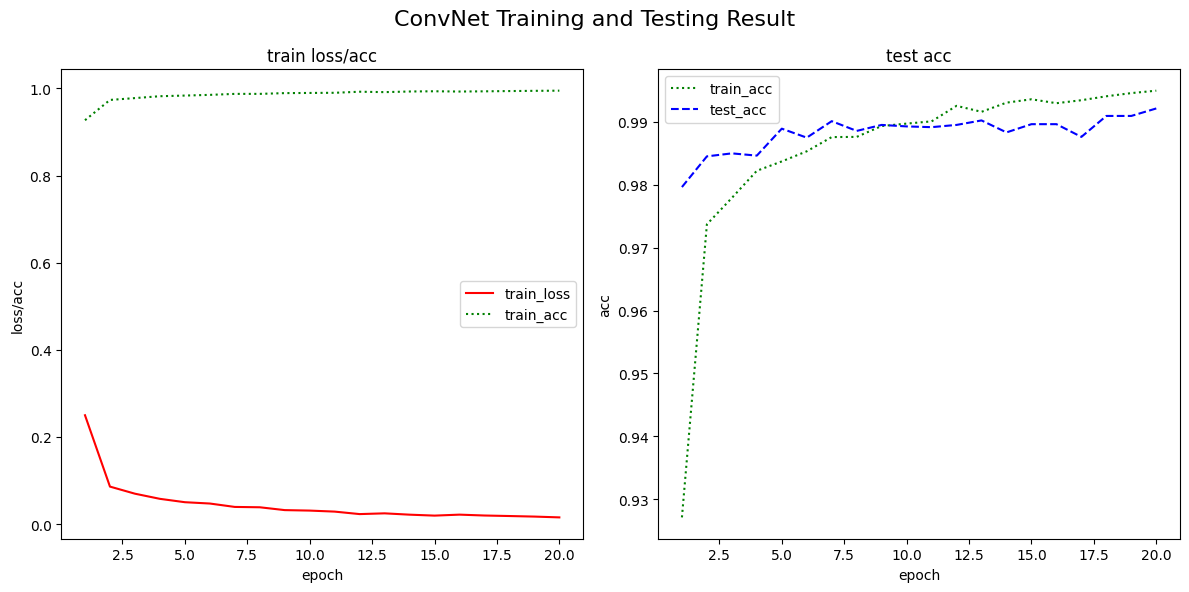

In [75]:
paint(title, loss, train_acc, test_acc, epochs)

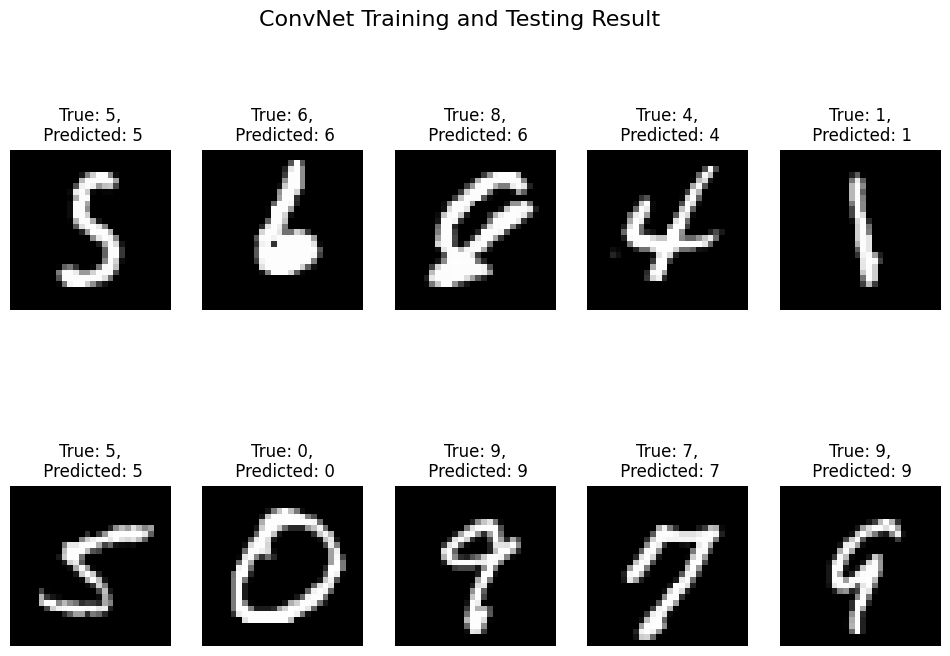

In [76]:
X, y = next(iter(val_dataloader))
#X = X.unsqueeze(0) 
output = model(X.to(device))
pred_y = torch.argmax(output, dim=1).tolist()
plt.figure(figsize=(12, 8))

for i in range(10):
    image, target = X[i], y[i]
    # Get predicted class
    # Display the image
    plt.subplot(2, 5, i + 1)
    #np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0))
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {target},\n Predicted: {pred_y[i]}")
    plt.axis('off')
plt.suptitle(title + ' Training and Testing Result', fontsize=16)
plt.show()


In [82]:
test_data = pd.read_csv("./Datasets/digit-recognizer/test.csv")
sub = pd.read_csv('./Datasets/digit-recognizer/sample_submission.csv')
test_images = test_data.values
test_images = torch.tensor(test_images, dtype=torch.float32)
test_images = test_images.view(-1, 1, 28, 28)

test_set = TensorDataset(test_images)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
pred_test = []
for data in test_loader:
    image = data[0]
    output = model(image.to(device))
    pred_t = torch.argmax(output, dim=1).tolist()

    pred_test += pred_t
sub['Label'] = pred_test
sub.to_csv('submission_.csv', index=False)